# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = '/home/renato/Documentos/data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

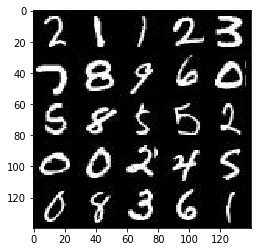

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

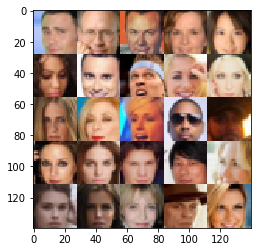

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    real_dim_ = tf.placeholder(tf.float32, [None, image_width, image_height ,image_channels], name= 'real_dim')
    z_dim_ = tf.placeholder(tf.float32, [None, z_dim], name='z_dim')
    lr_ = tf.placeholder(tf.float32, name='lr')

    return real_dim_, z_dim_, lr_


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [47]:
def discriminator(images, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 2, strides=2, padding='same')
        x = tf.maximum(x, alpha * x)
        
        x = tf.layers.conv2d(x, 128, 2, strides=2, padding='same')
        x = tf.maximum(x, alpha * x)
        x = tf.layers.batch_normalization(x, training=True)
        
        x = tf.layers.conv2d(x, 256, 2, strides=2, padding='same')
        x = tf.maximum(x, alpha * x)
        x = tf.layers.batch_normalization(x, training=True)
        
        logits = tf.layers.dense(tf.reshape(x, [-1, 4*4*256]), 1)
        output = tf.nn.sigmoid(logits)
        
        return logits, output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [65]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        
        x = tf.reshape(x, [-1,7,7,256])
        x = tf.maximum(x*alpha,x)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.maximum(x*alpha,x)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.maximum(x*alpha, x)
        x = tf.layers.batch_normalization(x, training=True)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=1, padding='same')
        x = tf.maximum(x*alpha, x)
        x = tf.layers.batch_normalization(x, training=True)
                
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same')
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [66]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim)
    
    disc_fake_model, fake_logits = discriminator(g_model)
    disc_real_model, real_logits = discriminator(input_real, reuse=True)
    
    disc_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_logits,
            labels=tf.zeros_like(fake_logits)))
    
    disc_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=real_logits,
            labels=tf.ones_like(real_logits)*(0.9)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_logits,
            labels=tf.ones_like(fake_logits)))
    
    return disc_fake_loss + disc_real_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [67]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    all_vars = tf.trainable_variables()
    
    g_vars = [var for var in all_vars if 'generator' in var.name]
    d_vars = [var for var in all_vars if 'discriminator' in var.name]
    
    g_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    d_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [68]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [69]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    real_input, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real_input, z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={real_input:batch_images, z:batch_z, lr:learning_rate})
                sess.run(g_opt, feed_dict={real_input:batch_images, z:batch_z, lr:learning_rate})
                
                if batch_i % 256 == 0:
                    train_loss_d = d_loss.eval({z:batch_z, real_input:batch_images})
                    train_loss_g = g_loss.eval({z:batch_z})
                    
                    print('batch {}'.format(batch_i),
                          'discriminator loss: {:.4f}'.format(train_loss_d),
                          'generator loss: {:.4f}'.format(train_loss_g))
                    
                    show_generator_output(sess, 16, z, data_shape[3], data_image_mode)
                
            show_generator_output(sess, 16, z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

batch 0 discriminator loss: 1.7635 generator loss: 0.3184


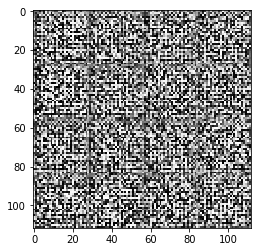

batch 256 discriminator loss: 1.1724 generator loss: 0.6454


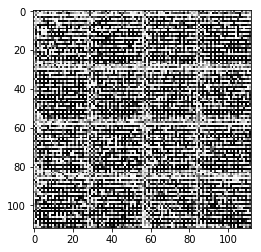

batch 512 discriminator loss: 1.2001 generator loss: 0.6282


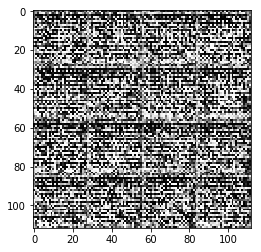

batch 768 discriminator loss: 1.1637 generator loss: 0.6539


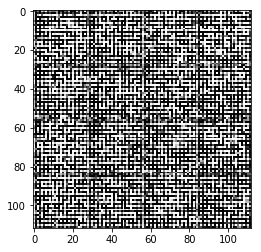

batch 1024 discriminator loss: 1.3119 generator loss: 0.5560


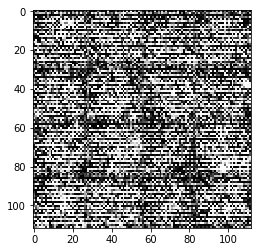

batch 1280 discriminator loss: 1.1495 generator loss: 0.6632


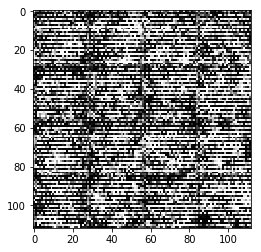

batch 1536 discriminator loss: 1.1476 generator loss: 0.6643


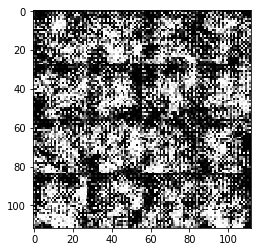

batch 1792 discriminator loss: 1.1481 generator loss: 0.6633


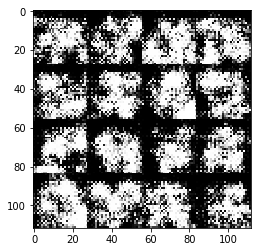

batch 2048 discriminator loss: 1.1166 generator loss: 0.6839


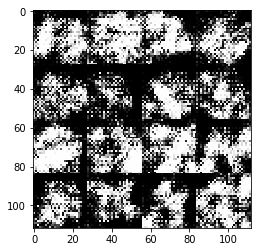

batch 2304 discriminator loss: 1.1197 generator loss: 0.6815


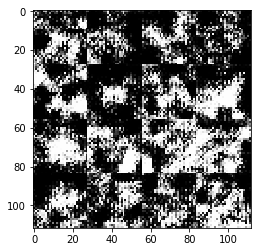

batch 2560 discriminator loss: 1.1084 generator loss: 0.6913


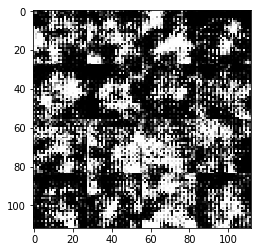

batch 2816 discriminator loss: 1.1409 generator loss: 0.6671


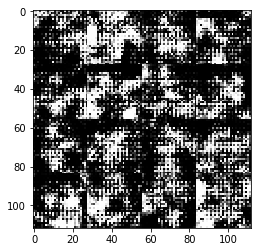

batch 3072 discriminator loss: 1.1069 generator loss: 0.6928


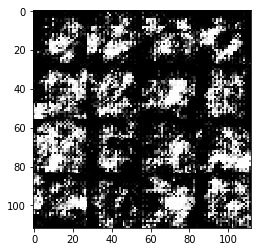

batch 3328 discriminator loss: 1.1534 generator loss: 0.6706


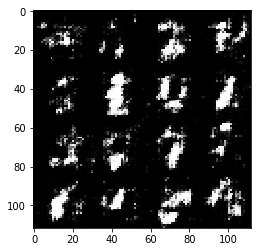

batch 3584 discriminator loss: 1.3948 generator loss: 0.5159


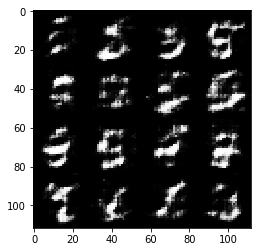

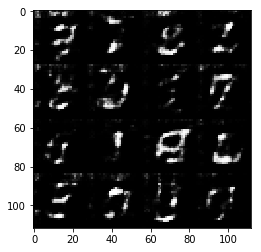

batch 0 discriminator loss: 1.3708 generator loss: 0.5364


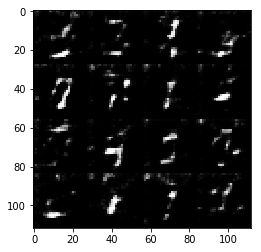

batch 256 discriminator loss: 1.4538 generator loss: 0.4584


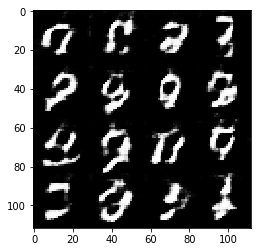

batch 512 discriminator loss: 1.4725 generator loss: 0.4627


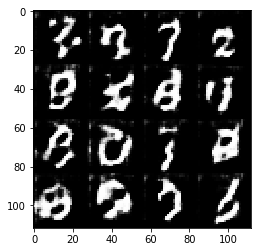

batch 768 discriminator loss: 1.2627 generator loss: 0.5802


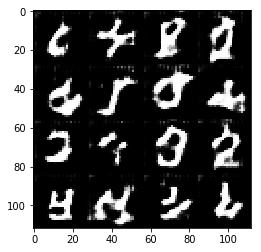

batch 1024 discriminator loss: 1.4392 generator loss: 0.4675


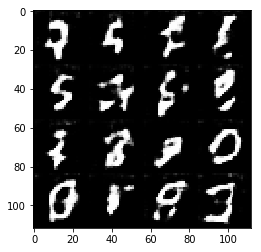

batch 1280 discriminator loss: 1.1209 generator loss: 0.6884


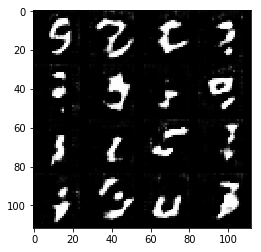

batch 1536 discriminator loss: 1.3291 generator loss: 0.5453


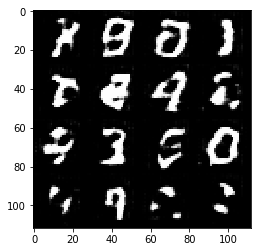

batch 1792 discriminator loss: 1.2317 generator loss: 0.6037


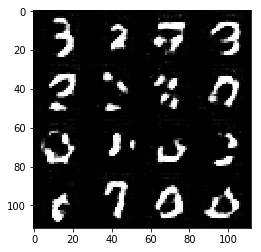

batch 2048 discriminator loss: 1.1906 generator loss: 0.6307


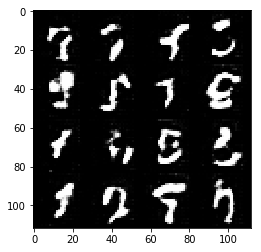

batch 2304 discriminator loss: 1.3989 generator loss: 0.4940


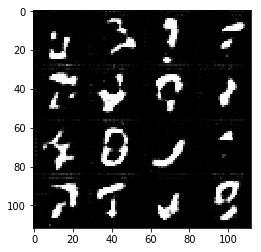

batch 2560 discriminator loss: 1.1300 generator loss: 0.6834


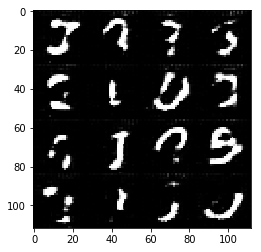

batch 2816 discriminator loss: 1.2556 generator loss: 0.5883


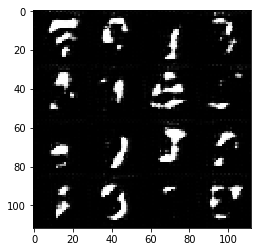

batch 3072 discriminator loss: 1.1971 generator loss: 0.6599


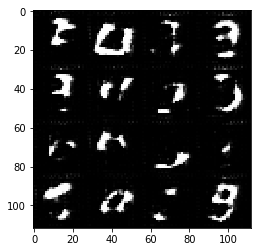

batch 3328 discriminator loss: 1.2390 generator loss: 0.6615


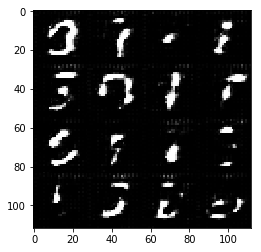

batch 3584 discriminator loss: 1.1962 generator loss: 0.6236


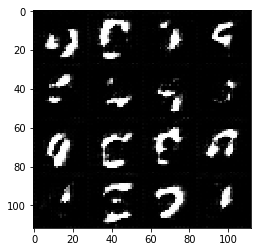

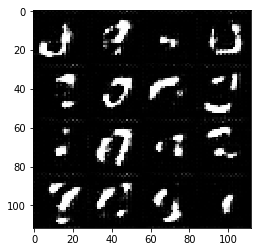

In [76]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

batch 0 discriminator loss: 1.7898 generator loss: 0.3136


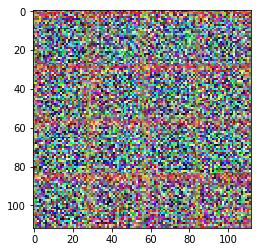

batch 256 discriminator loss: 1.4438 generator loss: 0.4666


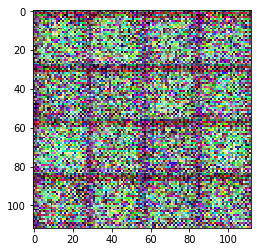

batch 512 discriminator loss: 1.1695 generator loss: 0.6521


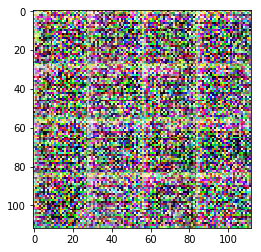

batch 768 discriminator loss: 1.1203 generator loss: 0.6811


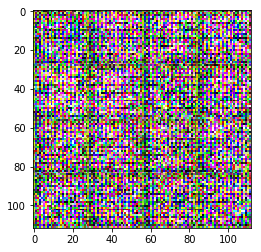

batch 1024 discriminator loss: 1.1840 generator loss: 0.6370


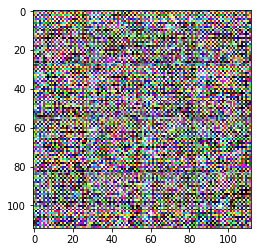

batch 1280 discriminator loss: 1.1261 generator loss: 0.6752


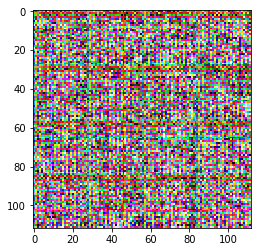

batch 1536 discriminator loss: 1.1913 generator loss: 0.6383


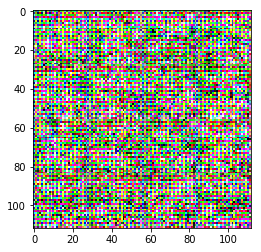

batch 1792 discriminator loss: 1.1200 generator loss: 0.6818


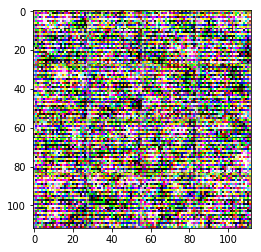

batch 2048 discriminator loss: 1.1120 generator loss: 0.6877


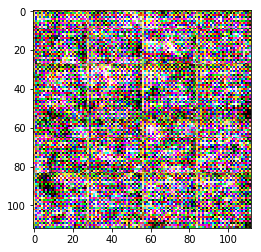

batch 2304 discriminator loss: 1.1305 generator loss: 0.6752


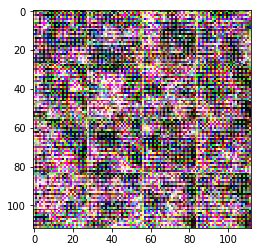

batch 2560 discriminator loss: 1.1074 generator loss: 0.6923


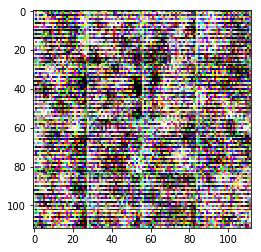

batch 2816 discriminator loss: 1.1155 generator loss: 0.6851


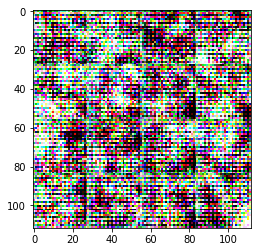

batch 3072 discriminator loss: 1.1084 generator loss: 0.6912


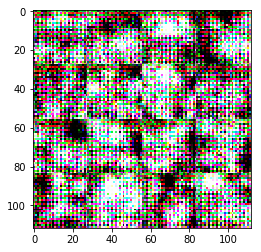

batch 3328 discriminator loss: 1.1067 generator loss: 0.6928


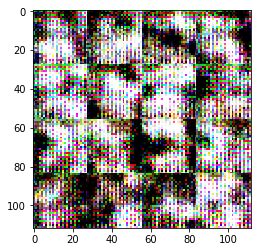

batch 3584 discriminator loss: 1.1082 generator loss: 0.6914


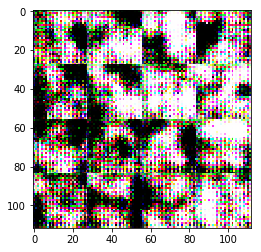

batch 3840 discriminator loss: 1.1075 generator loss: 0.6923


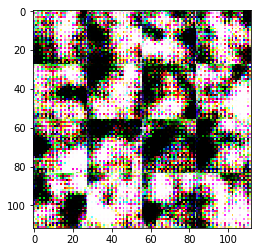

batch 4096 discriminator loss: 1.1107 generator loss: 0.6891


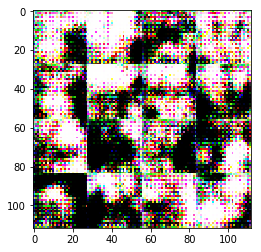

batch 4352 discriminator loss: 1.1077 generator loss: 0.6919


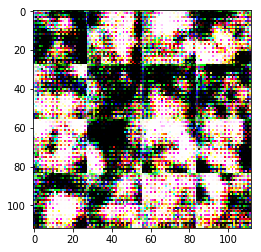

batch 4608 discriminator loss: 1.1066 generator loss: 0.6930


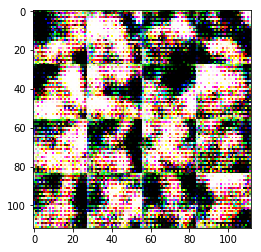

batch 4864 discriminator loss: 1.1065 generator loss: 0.6931


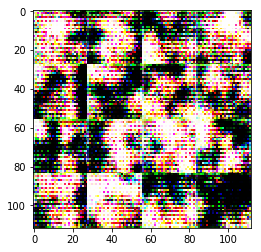

batch 5120 discriminator loss: 1.1065 generator loss: 0.6931


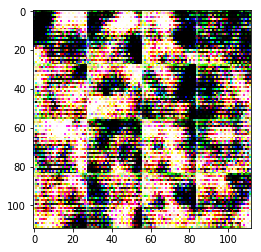

batch 5376 discriminator loss: 1.1066 generator loss: 0.6929


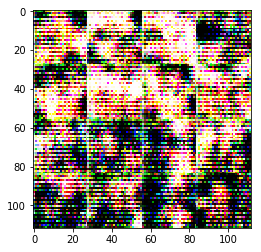

batch 5632 discriminator loss: 1.1066 generator loss: 0.6930


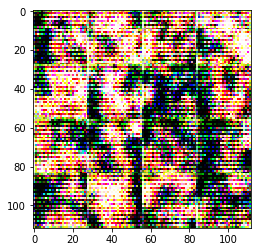

batch 5888 discriminator loss: 1.1064 generator loss: 0.6931


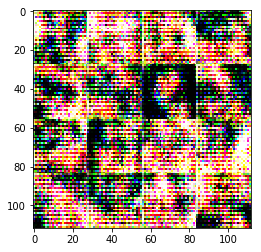

batch 6144 discriminator loss: 1.1068 generator loss: 0.6928


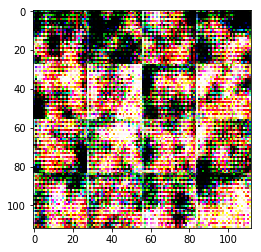

batch 6400 discriminator loss: 1.1065 generator loss: 0.6931


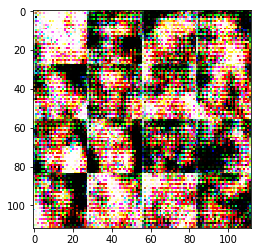

batch 6656 discriminator loss: 1.1064 generator loss: 0.6931


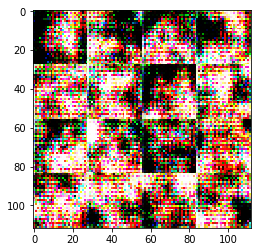

batch 6912 discriminator loss: 1.1064 generator loss: 0.6931


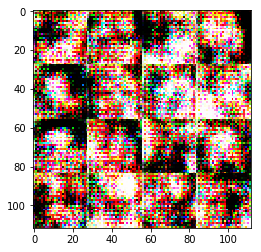

batch 7168 discriminator loss: 1.1066 generator loss: 0.6930


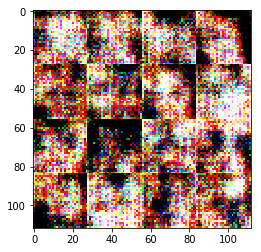

batch 7424 discriminator loss: 1.1065 generator loss: 0.6931


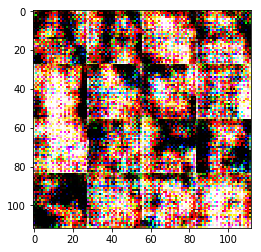

batch 7680 discriminator loss: 1.1064 generator loss: 0.6931


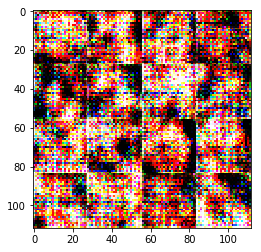

batch 7936 discriminator loss: 1.1064 generator loss: 0.6931


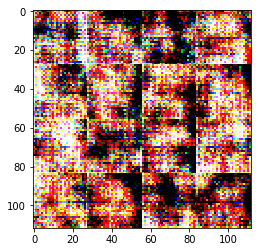

batch 8192 discriminator loss: 1.1064 generator loss: 0.6931


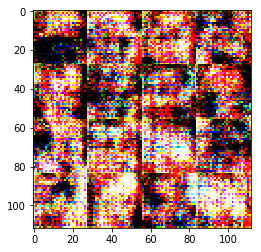

batch 8448 discriminator loss: 1.1064 generator loss: 0.6931


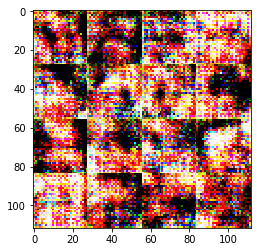

batch 8704 discriminator loss: 1.1064 generator loss: 0.6931


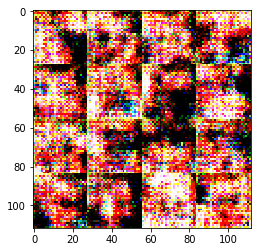

batch 8960 discriminator loss: 1.1064 generator loss: 0.6931


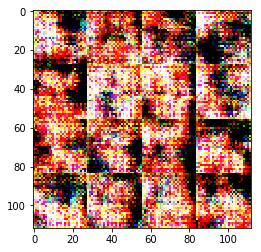

batch 9216 discriminator loss: 1.1064 generator loss: 0.6931


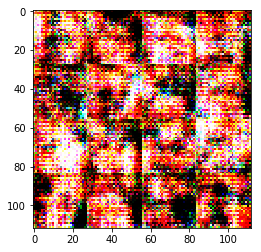

batch 9472 discriminator loss: 1.1064 generator loss: 0.6931


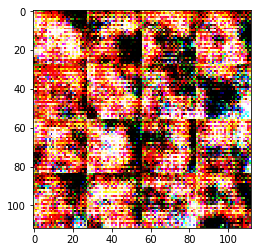

batch 9728 discriminator loss: 1.1064 generator loss: 0.6931


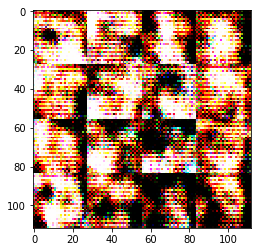

batch 9984 discriminator loss: 1.1453 generator loss: 0.6692


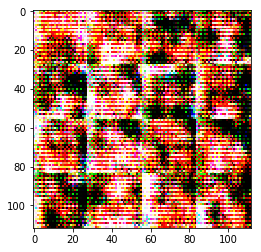

batch 10240 discriminator loss: 1.1152 generator loss: 0.6855


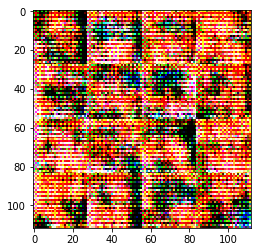

batch 10496 discriminator loss: 1.1605 generator loss: 0.6568


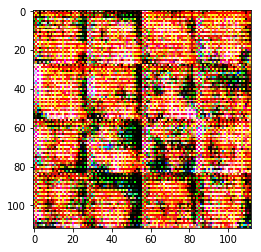

batch 10752 discriminator loss: 1.1064 generator loss: 0.6931


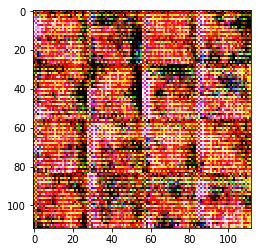

batch 11008 discriminator loss: 1.1064 generator loss: 0.6931


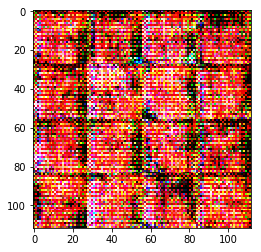

batch 11264 discriminator loss: 1.1064 generator loss: 0.6931


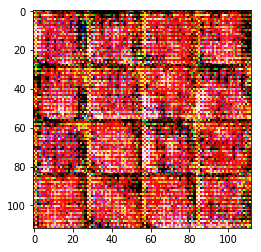

batch 11520 discriminator loss: 1.1395 generator loss: 0.6716


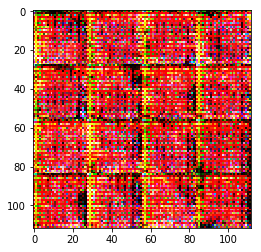

batch 11776 discriminator loss: 1.1064 generator loss: 0.6931


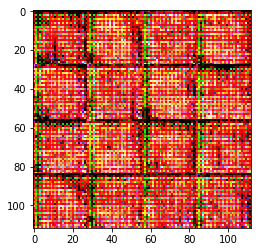

batch 12032 discriminator loss: 1.1064 generator loss: 0.6931


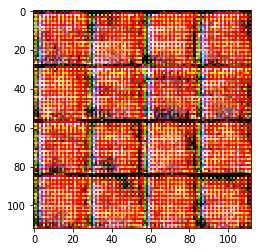

batch 12288 discriminator loss: 1.1065 generator loss: 0.6931


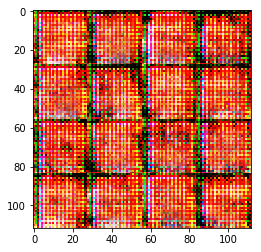

batch 12544 discriminator loss: 1.1064 generator loss: 0.6931


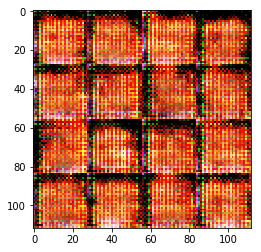

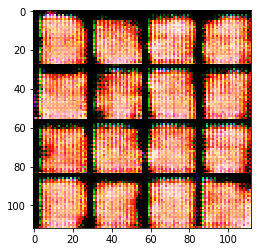

In [79]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = 0.6

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.